<a href="https://colab.research.google.com/github/bork0047/Android-Studio-Coursework/blob/main/Text%20Classification%20with%20Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Keras models for text classification
In this notebook I will explore:
  

1.   How to wrap Keras models with sklearn's pipeline and gridsearch constructs. 
2.   How to use Keras Dense layers to create a multi-layer neural net 
3.   How to use a convolutional NN with a Conv1D layer; and finally
4.   How to create a LSTM sequence model with an embedding layer to represent each token whilst maintaining their sequence. 

All examples in this book relate to the IMDB binary classification task. However I will be able to adapt code from here to create alternative model architectures and apply them to other text classification tasks.

In [ ]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# feature selection
from sklearn.feature_selection import SelectKBest, chi2

#import regular expressions to clean up the text
import re

#metrics
from sklearn.metrics import classification_report, accuracy_score

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

#import sklearn's FunctionTransformer to create a transformer
from sklearn.preprocessing import FunctionTransformer

#Import the sequential architecture
from keras.models import Sequential
#Import the different layers needed to create a CNN
#First, import your convolutional and max pooling layers
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization, TextVectorization
#Next, we import the dense (fully-connected) and embedding layers
from keras.layers import Dense, Embedding, LSTM
#Finally, import your layer activations and regulizers - in this case, dropout and activation functions
from keras.layers import Dropout, Activation
from tensorflow.keras.utils import to_categorical


#Keras offers us the ability to import datasets directly into our code using a number of presets.
#We can import all the datasets at once, but it consumes memory, so its better to import only the required one.
from keras.datasets import imdb

# fix random seed for reproducibility
np.random.seed(1337)
state_ = np.random.get_state()[1][0]

# 1. Preprocess and Load the data

##1.1 Load the data

In [ ]:
data_file = "https://raw.githubusercontent.com/nirmalie/CM4107/main/movie_data_cat.csv"
# class_index = 1 # on inspection of the csv file we see that the class appears in 1st position
df = pd.read_csv(data_file,  encoding='utf-8')
print('Shape:', df.shape)

num_classes = 2
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}

print("class_mapping:" , class_mapping)

#use the mapping dictionary to transform the class labels into integers

df['sentiment'] = df['sentiment'].map(class_mapping)

Shape: (50000, 2)
class_mapping: {'neg': 0, 'pos': 1}


In [ ]:
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


##1.2 Create a train and test sample to work with

In [ ]:
small_df= df.sample(frac=0.01, replace=False, random_state=state_)
X = small_df.loc[:, 'review'].values
y = small_df.loc[:, 'sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=state_,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)
y_test_ohe = to_categorical(y_test, num_classes)
y_train_ohe = to_categorical(y_train, num_classes)
print('x_train shape:', X_train.shape)
print('y_train_ohe shape:', y_train_ohe.shape)
print('x_test shape:', X_test.shape)
print('y_test_ohe shape:', y_train_ohe.shape)
print(X_train[0:5])
print(y_train_ohe[0:5])


x_train shape: (350,)
y_train_ohe shape: (350, 2)
x_test shape: (150,)
y_test_ohe shape: (350, 2)
["I tried to give this show a chance, but it really doesn't sit well with me. Although the performances are good, the writing isn't. The two oldest step-siblings, Derek and Casey, are equally annoying; I get the impression that we're supposed to side with Casey, given that she's the protagonist, but I don't find her at all likable. The parents are continually portrayed as utterly clueless. The three younger children are the most watchable things on the show; Lizzie and Edwin are sweet the way they team up, and Marti is adorable. The plot lines are a bit far-fetched and the whole premise is mostly hard to swallow -- blended families are common, yes, but this family isn't really trying all that hard to blend. On the whole, I think it grades thumbs-down."
 "Before Sunrise is romance for the slacker generation. Richard Linklater's romantic drama is an offbeat telling of a dream come true for m

In [ ]:
df=pd.DataFrame(X_train, columns=['sentences'])
df.head()
VOCAB_SIZE = set(df['sentences'].str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())
print("Vocabulary approx size: ")
len(VOCAB_SIZE)

Vocabulary approx size: 


<ipython-input-5-c0e059bcf5e4>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  VOCAB_SIZE = set(df['sentences'].str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())


10693

Review length: 
Mean 1264.02 words (885.970377) in a review


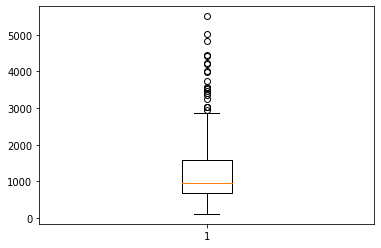

In [ ]:
from matplotlib import pyplot

# Summarize review length
print("Review length: ")
result = [len(x) for x in df.sentences]
print("Mean %.2f words (%f) in a review" % (np.mean(result), np.std(result)))

AVG_REVIEW_LEN = np.mean(result)

# plot review length
pyplot.boxplot(result)
pyplot.show()

##1.3 Preprocess the data

In [ ]:
nltk.download('stopwords')
#get the english stopwords
stop = set(stopwords.words('english'))
#print("Number of stopwords:", len(stop))

#get the english stemmer
stemmer = SnowballStemmer("english")

def tokenizer(text):
       return text.split()
 
def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]

def text_cleanup(X, lowercase):  #lowercase: True to convert to lowercase or False to leave case as they are
    # print('in text_cleanup...')
    # print('lowercase:', lowercase)
    XX = np.copy(X)  # get copy of the data
    for index, text in enumerate(XX):
        text = re.sub('<[^>]*>', '', text) # remove all html markup ; re.sub(A, B, C) will Replace A with B in the string C.
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons re.findall(A, B) | Matches all instances of an expression A in a string B and returns them in a list.
        
        # remove the non-word chars '[\W]+'
        # append the emoticons to end 
        # conditionally convert all to lowercase
        # remove nose char for consistency
        if lowercase:
            text = text.lower()
        text = (re.sub('[\W]+', ' ', text) +
                ' '.join(emoticons).replace('-', ''))
        XX[index] = text

    return XX

#creating text_cleanup object using FunctionTransformer
text_cleanup_preprocessor = FunctionTransformer(text_cleanup, kw_args={'lowercase': True})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Wrapping Keras models to work with sklearn Pipelines and Gridsearch
We need to use some of the Keras wrappers first before we can use the sklearn pipeline and grid constructs.  

In [ ]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Get the keras wrappers for scikitlearn

In [ ]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

# 2.1. Pipeline and GridSearch with a Keras Dense layer
We can create a basic ANN (or MLP) with as many hidden layers as we want. 

### Create a Keras NN model with multiple Dense layers

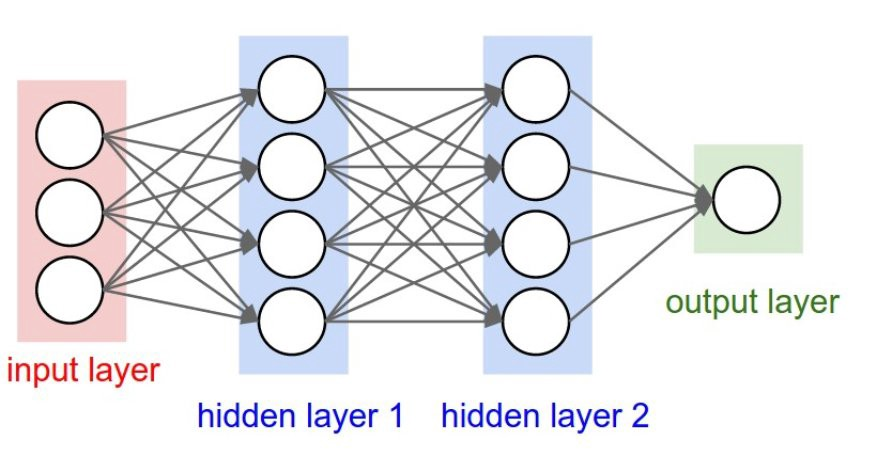

In [ ]:
def create_model(meta, hidden_layer_sizes=[128, 64], optimizer="adam", dropout=0.5):
    n_features_in_ = meta["n_features_in_"]
    print("n_features_in_", n_features_in_)
    n_classes_ = meta["n_classes_"]
    print("n_classes_", n_classes_)

    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(n_features_in_,)))
    model.add(Dropout(dropout) )

    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense ( hidden_layer_size, activation="relu"))
        model.add(Dropout(dropout))

    model.add(Dense(n_classes_, activation="softmax"))
    print("meta", model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

### Setup the pipe and gridsearch for the multi-layer NN

In [ ]:
keras_clf = KerasClassifier(build_fn=create_model, verbose=1)# Wrapped Keras classifier

pipe = Pipeline([
    ('tcp', text_cleanup_preprocessor),
    ('vect', TfidfVectorizer()),
    ('fs',   SelectKBest(chi2, k = 100)), # k finds the top features 
    ('clf', keras_clf)
])

params = {
    'vect__ngram_range': [(1,1)],# (1,2)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
    'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer 
    'vect__stop_words': [None], # use the stop dictionary of stopwords or not
    'clf__optimizer': ['rmsprop'],
    'clf__batch_size': [(20), (50)],
    'clf__epochs': [20]
}

pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tcp', 'vect', 'fs', 'clf', 'tcp__accept_sparse', 'tcp__check_inverse', 'tcp__func', 'tcp__inv_kw_args', 'tcp__inverse_func', 'tcp__kw_args', 'tcp__validate', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__norm', 'vect__preprocessor', 'vect__smooth_idf', 'vect__stop_words', 'vect__strip_accents', 'vect__sublinear_tf', 'vect__token_pattern', 'vect__tokenizer', 'vect__use_idf', 'vect__vocabulary', 'fs__k', 'fs__score_func', 'clf__model', 'clf__build_fn', 'clf__warm_start', 'clf__random_state', 'clf__optimizer', 'clf__loss', 'clf__metrics', 'clf__batch_size', 'clf__validation_batch_size', 'clf__verbose', 'clf__callbacks', 'clf__validation_split', 'clf__shuffle', 'clf__run_eagerly', 'clf__epochs', 'clf__class_weight'])

In [ ]:
grid = GridSearchCV(pipe, params, n_jobs=-1, cv=3, verbose=True)

grid.fit(X_train, y_train_ohe)

print(grid.best_score_, grid.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
n_features_in_ 100
n_classes_ 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                               

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


18/18 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.5229
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.6000
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.7143
Epoch 4/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.7543
Epoch 5/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5124 - accuracy: 0.8143
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.3890 - accuracy: 0.8400
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.2811 - accuracy: 0.8914
Epoch 8/20
18/18 [==============================] - 0s 3ms/step - loss: 0.2472 - accuracy: 0.8914
Epoch 9/20
18/18 [==============================] - 0s 3ms/step - loss: 0.2317 - accuracy: 0.9171
Epoch 10/20
18/18 [==============================] - 0s 3ms/step - loss: 0.2110 - accuracy: 0.9229
Epoch 11/20
18/18 [===========

### Run the best estimator hyper parameters on the test data

In [ ]:
imdb_clf = grid.best_estimator_
score = imdb_clf.score(X_test, y_test_ohe)
print('Test Accuracy: %.2f%%' % (score *100) )

# detailed report on test data using classification_report
y_pred_ohe = imdb_clf.predict(X_test)
print(classification_report(y_test_ohe, y_pred_ohe))

8/8 [==============================] - 0s 2ms/step
Test Accuracy: 76.67%
8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.85      0.78        74
           1       0.83      0.68      0.75        76

   micro avg       0.77      0.77      0.77       150
   macro avg       0.77      0.77      0.77       150
weighted avg       0.78      0.77      0.77       150
 samples avg       0.77      0.77      0.77       150



## <font color='red'>Exercise 2.1 </font> BOW representation with Keras Dense layers. 
Try to improve the architecture model architecture in order to increase accuracy on test data. 

# 2.2. Pipeline and GridSearch with a Conv1D layer

Here we need to create a special transformer layer in case we want to use sklearn's transformers (such as tfidfvectoriser). 
The DenseTransformer method that we create ensures that the sparse matrix output from the tfidf vectoriser is converted in to a full dense matrix before it can be input to the Conv1D layer.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


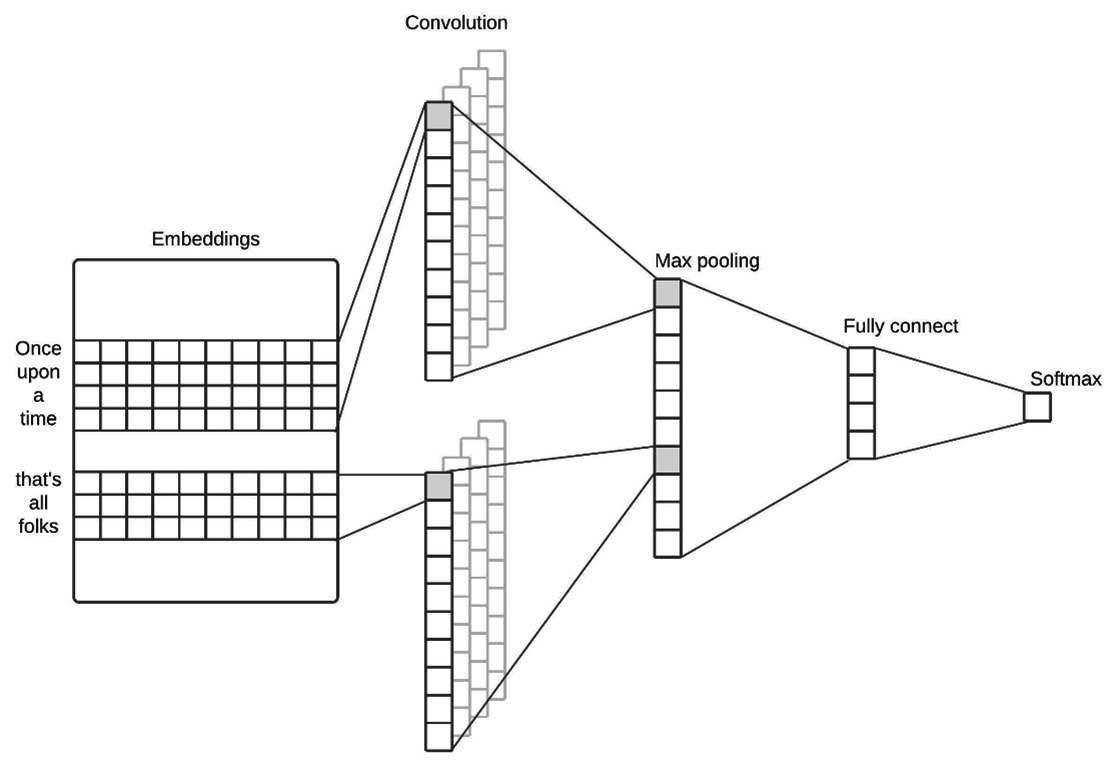

### Create the CNN model using a Conv1D layer

In [ ]:
def create_model_CNN(meta, optimizer="adam", dropout=0.5, learning_rate = 0.1):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    print("n_features_in_", n_features_in_)

    print ("Creating a CNN model")
    print("n_classes_", n_classes_)
    model = Sequential()

    model.add(Conv1D(filters=500, kernel_size=3, padding='same', activation='relu', strides=1, input_shape=(n_features_in_, 1 )))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=50, kernel_size=3, padding='same', activation='relu', strides=1))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D()) # best to have a global pooling before the Dense layer as it down samples to 2 dimensions needed for Dense

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout) )

    model.add(BatchNormalization())
    model.add(Dense(n_classes_, activation='softmax'))
    print("meta", model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

### Create the pipe, gridsearch and execute for the CNN using tfidf vectoriser

In [ ]:
keras_cnn_clf = KerasClassifier(build_fn=create_model_CNN, verbose=1)

pipe = Pipeline([
    ('tcp', text_cleanup_preprocessor),
    ('vect', TfidfVectorizer()),
    ('fs',   SelectKBest(chi2, k = 100)),
    ('to_dense', DenseTransformer()), 
    ('clf', keras_cnn_clf)
])

params = {
    'vect__ngram_range': [(1,1)],# (1,2)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
    'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer 
    'vect__stop_words': [None], # use the stop dictionary of stopwords or not
    'clf__optimizer': ['rmsprop'],
    'clf__epochs': [10]
}

pipe.get_params().keys()

grid_cnn = GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=3, verbose=True)

grid_cnn.fit(X_train, y_train_ohe)

print(grid_cnn.best_score_, grid_cnn.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
n_features_in_ 100
Creating a CNN model
n_classes_ 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 500)          2000      
                                                                 
 batch_normalization (BatchN  (None, 100, 500)         2000      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 500)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 50)            75050     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50)           200       
 hNormal

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


                                                                 
Total params: 86,548
Trainable params: 85,192
Non-trainable params: 1,356
_________________________________________________________________
meta None
Epoch 1/10
11/11 [==============================] - 2s 84ms/step - loss: 0.8743 - accuracy: 0.5229
Epoch 2/10
11/11 [==============================] - 1s 81ms/step - loss: 0.8302 - accuracy: 0.5343
Epoch 3/10
11/11 [==============================] - 1s 82ms/step - loss: 0.8237 - accuracy: 0.5200
Epoch 4/10
11/11 [==============================] - 1s 80ms/step - loss: 0.7522 - accuracy: 0.5343
Epoch 5/10
11/11 [==============================] - 1s 80ms/step - loss: 0.7873 - accuracy: 0.5657
Epoch 6/10
11/11 [==============================] - 1s 83ms/step - loss: 0.7408 - accuracy: 0.5657
Epoch 7/10
11/11 [==============================] - 1s 80ms/step - loss: 0.7288 - accuracy: 0.5714
Epoch 8/10
11/11 [==============================] - 1s 82ms/step - loss: 0.7157 - accuracy:

### Run the best estimator on the test data

In [ ]:
imdb_cnn_clf = grid_cnn.best_estimator_
score =  imdb_cnn_clf.score(X_test, y_test_ohe)
print('Test Accuracy: %.2f%%' % (score *100) )

# detailed report on test data using classification_report
y_pred_ohe = imdb_cnn_clf.predict(X_test)
print(classification_report(y_test_ohe, y_pred_ohe))

1/5 [=====>........................] - ETA: 0s

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


5/5 [==============================] - 0s 17ms/step
Test Accuracy: 49.33%
5/5 [==============================] - 0s 16ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


              precision    recall  f1-score   support

           0       0.49      1.00      0.66        74
           1       0.00      0.00      0.00        76

   micro avg       0.49      0.49      0.49       150
   macro avg       0.25      0.50      0.33       150
weighted avg       0.24      0.49      0.33       150
 samples avg       0.49      0.49      0.49       150



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <font color='red'>Exercise 2.2</font> BOW representation with Keras Conv1D layers. 
Try to improve the model's architecture in order to increase accuracy on test data.
However we will see that to truly improve the performance of a CNN we will need to take into consideration the sequence of text (i.e. a sequence aware input layer rather than a BoW vectoriser approach). 

# 3. Using Keras embedding input layers
A CNN's convolution layers work hard to recognise patterns in the local viscinity. Therefore if we can create a representation that is aware of word order (unlike a BoW) then it is more likely that we would be able to benefit from convolved architectures. 

In order to do that we need to use Keras' own tokeniser and embedding layers (instead of the tfidf vectoriser). 

In [ ]:
from keras_preprocessing.text import Tokenizer
import keras
#Import sequence preprocessing methods
from keras_preprocessing import sequence
from keras.utils import pad_sequences

## 3.1 Create a text preprocessor using the keras tokeniser and its padding function.


In [ ]:
vocab = 4000 #VOCAB_SIZE 
maxlen = 400 # AVG_REVIEW_LEN #400

def text_padding(X, vocab, maxlen):  #lowercase: True to convert to lowercase or False to leave case as they are
    #vocab=4000
    #maxlen=400
    XX = np.copy(X)  # get copy of the data
    tokeniser = Tokenizer(num_words=vocab) # filters to frequent unique words
    tokeniser.fit_on_texts(XX)
    XX_vec = tokeniser.texts_to_sequences(XX) 
    XX_vocab_size = len(tokeniser.word_index) + 1 # Adding 1 because of reserved 0 index
    XX_train_pad = pad_sequences(XX_vec, maxlen=maxlen) # pads upto the max len
    #print("This is what a review now looks like \n", XX_train_pad[0])
    return XX_train_pad

#creating text_cleanup object using FunctionTransformer
text_padding_preprocessor = FunctionTransformer(text_padding, kw_args={'vocab': vocab, 'maxlen': maxlen})

### Create the Pipeline and run gridsearch using the Keras padding preprocessor
We will use the newly created text preprocessor with our simple CNN model (in create_model_CNN) to provide a representation that maintains the sequence of words (stored as IDs) and extra padding to make sure every review vector is of the same length when input to a keras layer. 

Once the input is in a vector format as we need for gridsearch; we can use this as input into a CNN. 

This means that you can now compare the models on text classification with the CNN model using similar text pre-processing steps. 

In [ ]:
keras_cnn_clf2 = KerasClassifier(build_fn=create_model_CNN, verbose=1)
pipe = Pipeline([ 
    ('tcp', text_cleanup_preprocessor),
    ('tpp', text_padding_preprocessor),
    ('clf', keras_cnn_clf2)
])

params = {

    'clf__optimizer': ['rmsprop'],
    'clf__epochs': [10]
}

pipe.get_params().keys() 

dict_keys(['memory', 'steps', 'verbose', 'tcp', 'tpp', 'clf', 'tcp__accept_sparse', 'tcp__check_inverse', 'tcp__func', 'tcp__inv_kw_args', 'tcp__inverse_func', 'tcp__kw_args', 'tcp__validate', 'tpp__accept_sparse', 'tpp__check_inverse', 'tpp__func', 'tpp__inv_kw_args', 'tpp__inverse_func', 'tpp__kw_args', 'tpp__validate', 'clf__model', 'clf__build_fn', 'clf__warm_start', 'clf__random_state', 'clf__optimizer', 'clf__loss', 'clf__metrics', 'clf__batch_size', 'clf__validation_batch_size', 'clf__verbose', 'clf__callbacks', 'clf__validation_split', 'clf__shuffle', 'clf__run_eagerly', 'clf__epochs', 'clf__class_weight'])

In [ ]:
grid_cnn_tpp = GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=3, verbose=True)

grid_cnn_tpp.fit(X_train, y_train_ohe)

print(grid_cnn_tpp.best_score_, grid_cnn_tpp.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
n_features_in_ 400
Creating a CNN model
n_classes_ 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 400, 500)          2000      
                                                                 
 batch_normalization_3 (Batc  (None, 400, 500)         2000      
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 200, 500)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 50)           75050     
                                                                 
 batch_normalization_4 (Batc  (None, 200, 50)          200       
 hNormal

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


meta None
Epoch 1/10
11/11 [==============================] - 4s 273ms/step - loss: 0.9082 - accuracy: 0.5257
Epoch 2/10
11/11 [==============================] - 3s 272ms/step - loss: 0.8490 - accuracy: 0.5571
Epoch 3/10
11/11 [==============================] - 3s 276ms/step - loss: 0.8259 - accuracy: 0.5229
Epoch 4/10
11/11 [==============================] - 3s 273ms/step - loss: 0.8566 - accuracy: 0.4600
Epoch 5/10
11/11 [==============================] - 3s 273ms/step - loss: 0.8234 - accuracy: 0.5200
Epoch 6/10
11/11 [==============================] - 3s 275ms/step - loss: 0.7786 - accuracy: 0.5429
Epoch 7/10
11/11 [==============================] - 3s 273ms/step - loss: 0.7670 - accuracy: 0.5800
Epoch 8/10
11/11 [==============================] - 3s 273ms/step - loss: 0.7461 - accuracy: 0.5457
Epoch 9/10
11/11 [==============================] - 3s 276ms/step - loss: 0.7294 - accuracy: 0.5743
Epoch 10/10
11/11 [==============================] - 3s 276ms/step - loss: 0.6910 - accura

In [ ]:
imdb_cnn_clf2 = grid_cnn_tpp.best_estimator_
score =  imdb_cnn_clf2.score(X_test, y_test_ohe)
print('Test Accuracy: %.2f%%' % (score *100) )

# detailed report on test data using classification_report
y_pred_ohe = imdb_cnn_clf2.predict(X_test)
print(classification_report(y_test_ohe, y_pred_ohe))

5/5 [==============================] - 0s 51ms/step
Test Accuracy: 59.33%
5/5 [==============================] - 0s 55ms/step
              precision    recall  f1-score   support

           0       0.61      0.49      0.54        74
           1       0.58      0.70      0.63        76

   micro avg       0.59      0.59      0.59       150
   macro avg       0.60      0.59      0.59       150
weighted avg       0.60      0.59      0.59       150
 samples avg       0.59      0.59      0.59       150



# <font color='red'>Exercise 3.1</font> 
Compare the results of the basic CNN using the tfidf vectoriser and then without tfidf and instead using the  text_padding_preprocessor.

Try to modify the basic CNN model (in create_model_CNN ) to improve accuracy in test data. 

# 4. Using Keras Embedding layer with a sequence learner

A typical sequence learner such as LSTM will process a word / token at a time. To enable this we need to embed each token using the Embedding layer. This layer provides a vector representation for each word. 

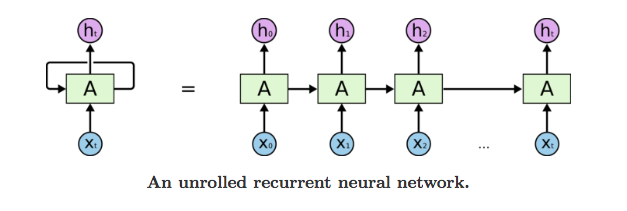

In [ ]:

vocab = 4000 #VOCAB_SIZE 
maxlen = 400 # AVG_REVIEW_LEN #400

def create_model_LSTM(vocab=vocab, max_review_length=maxlen, embedding_size=32, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(vocab, embedding_size, input_length=max_review_length))
    #model.add(LSTM(100, return_sequences=True)) # when stacking maintain the dimensions with return_sequences=True
    model.add(LSTM(10))
 
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    model.summary()
    return model

In [ ]:
keras_lstm_clf = KerasClassifier(build_fn=create_model_LSTM, verbose=1)

pipe = Pipeline([ 
    ('tcp', text_cleanup_preprocessor),
    ('tpp', text_padding_preprocessor),
    ('clf', keras_lstm_clf)
])

params = {
    'clf__optimizer': ['rmsprop'],
    'clf__batch_size': [20],
    'clf__epochs': [10]
}

pipe.get_params().keys()



dict_keys(['memory', 'steps', 'verbose', 'tcp', 'tpp', 'clf', 'tcp__accept_sparse', 'tcp__check_inverse', 'tcp__func', 'tcp__inv_kw_args', 'tcp__inverse_func', 'tcp__kw_args', 'tcp__validate', 'tpp__accept_sparse', 'tpp__check_inverse', 'tpp__func', 'tpp__inv_kw_args', 'tpp__inverse_func', 'tpp__kw_args', 'tpp__validate', 'clf__model', 'clf__build_fn', 'clf__warm_start', 'clf__random_state', 'clf__optimizer', 'clf__loss', 'clf__metrics', 'clf__batch_size', 'clf__validation_batch_size', 'clf__verbose', 'clf__callbacks', 'clf__validation_split', 'clf__shuffle', 'clf__run_eagerly', 'clf__epochs', 'clf__class_weight'])

In [ ]:
grid_lstm= GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=3, verbose=True)

grid_lstm.fit(X_train, y_train_ohe)

print(grid_lstm.best_score_, grid_lstm.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 32)           128000    
                                                                 
 lstm (LSTM)                 (None, 10)                1720      
                                                                 
 dense_8 (Dense)             (None, 2)                 22        
                                                                 
Total params: 129,742
Trainable params: 129,742
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18/18 [==============================] - 5s 134ms/step - loss: 0.6931 - accuracy: 0.4857
Epoch 2/10
18/18 [==============================] - 2s 132ms/step - loss: 0.6886 - accuracy: 0.7771
Epoch 3/10
18/18 [==============================] - 2s 132ms/step - loss: 0.6789 - accuracy: 0.8857
Epoch 4/10
1

In [ ]:
imdb_lstm_clf = grid_lstm.best_estimator_
score = imdb_lstm_clf.score(X_test, y_test_ohe)
print('Test Accuracy: %.2f%%' % (score *100) )

# detailed report on test data using classification_report
y_pred_ohe = imdb_lstm_clf.predict(X_test)
print(classification_report(y_test_ohe, y_pred_ohe))

8/8 [==============================] - 1s 22ms/step
Test Accuracy: 54.00%
8/8 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.54      0.51      0.52        74
           1       0.54      0.57      0.55        76

   micro avg       0.54      0.54      0.54       150
   macro avg       0.54      0.54      0.54       150
weighted avg       0.54      0.54      0.54       150
 samples avg       0.54      0.54      0.54       150



# MISC - ignore

In [ ]:
maxlen = 400 # we want to clip reviews that are longer than 400

# create the tokenizer
tokeniser = Tokenizer(num_words=4000)

# fit the tokenizer on the documents
tokeniser.fit_on_texts(X_train)

# summarize what was learned
print(tokeniser.word_counts)
print(tokeniser.word_index)
print(tokeniser.word_docs)
print('Num of training documents', tokeniser.document_count)


# integer encode documents
X_train_vec = tokeniser.texts_to_sequences(X_train) 
train_vocab_size = len(tokeniser.word_index) + 1 # Adding 1 because of reserved 0 index

X_test_vec = tokeniser.texts_to_sequences(X_test) 
test_vocab_size = len(tokeniser.word_index) + 1 # Adding 1 because of reserved 0 index

print ('train vocabulary size:', train_vocab_size)
print ('test vocabulary size:', test_vocab_size)

OrderedDict([('i', 1095), ('tried', 17), ('to', 1754), ('give', 54), ('this', 1045), ('show', 96), ('a', 2177), ('chance', 12), ('but', 602), ('it', 1080), ('really', 167), ("doesn't", 61), ('sit', 7), ('well', 149), ('with', 582), ('me', 173), ('although', 31), ('the', 4595), ('performances', 27), ('are', 379), ('good', 189), ('writing', 27), ("isn't", 31), ('two', 94), ('oldest', 1), ('step', 7), ('siblings', 1), ('derek', 2), ('and', 2177), ('casey', 2), ('equally', 10), ('annoying', 16), ('get', 123), ('impression', 2), ('that', 915), ("we're", 15), ('supposed', 19), ('side', 12), ('given', 26), ("she's", 20), ('protagonist', 6), ("don't", 105), ('find', 49), ('her', 266), ('at', 317), ('all', 342), ('likable', 9), ('parents', 6), ('continually', 3), ('portrayed', 11), ('as', 655), ('utterly', 6), ('clueless', 1), ('three', 31), ('younger', 5), ('children', 18), ('most', 135), ('watchable', 9), ('things', 43), ('on', 472), ('lizzie', 1), ('edwin', 1), ('sweet', 11), ('way', 109), (

In [ ]:
# NOTE: padding is not needed when using tfidf sparce representations
print('Pad sequences (samples x time)')
X_train_pad = pad_sequences(X_train_vec, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_vec, maxlen=maxlen)

#Print the data's shape (i.e. the size of each dimension) to check this is done correctly.
print('x_train shape:', X_train_pad.shape)
print('x_test shape:', X_test_pad.shape)
print('After padding the example looks:')
print(X_train_pad[0])
print(len(X_train_pad[0]))

Pad sequences (samples x time)


NameError: ignored

In [ ]:
keras_cnn_clf2 = KerasClassifier(build_fn=create_model_CNN, verbose=1)

pipe = Pipeline([ 
    ('clf', keras_cnn_clf2)
])

params = {
    'clf__optimizer': ['rmsprop'],
    'clf__epochs': [10]
}

pipe.get_params().keys()

grid_cnn2 = GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, verbose=True, cv=3)

grid_cnn2.fit(X_train_pad, y_train_ohe)

print(grid_cnn2.best_score_, grid_cnn2.best_params_)


NameError: ignored

In [ ]:
imdb_cnn_clf2 = grid_cnn2.best_estimator_
score = imdb_cnn_clf2.score(X_test_pad, y_test_ohe)
#print('Test Accuracy: %.3f' % imdb_cnn_clf2.score(X_test_pad, y_test_ohe))
print('Test Accuracy: %.2f%%' % (score *100) )

# detailed report on test data using classification_report
y_pred_ohe = imdb_cnn_clf2.predict(X_test_pad)
print(classification_report(y_test_ohe, y_pred_ohe))

NameError: ignored